##Import various python functions and modules that we need.

In [1]:
from pandas import DataFrame
from IPython.display import FileLink

##Pylab namespace and inline plots. Import Rmagic.

In [2]:
%matplotlib inline
%load_ext rpy2.ipython

##Import R libraries we'll use.

In [3]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(vegan)
library(dplyr)
library(plyr)
library(RColorBrewer)
library(stats)
library(stringr)
library(gdata)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: iterators

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: permute

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lattic

## Import data into R. Prune to relevant samples (Chazy). Get rid of OTUs not observed in at least 25% of samples)

In [4]:
%%R 
physeq = import_biom("data/otu_table_515SIP_wtax.biom", "data/otusn_515SIP.tree")
print(physeq)
sample.data = import_qiime_sample_data("data/Metadata_515806_Density.txt")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
print(physeq)
physeq = prune_samples(physeq.md$Treatment %in% c("12C", "13X") & (physeq.md$Day %in% c(1,3,7,14)) & (physeq.md$Full.sample != c("12C.NTH.D3.R4.Frac9")), physeq)
physeq.md = sample_data(physeq)
physeq.snorm = transform_sample_counts(physeq, function(x) x/sum(x))
physeq.thresh = filter_taxa(physeq.snorm, function(x) sum(x > 0) / length(x) > (0.25), TRUE)
print(physeq.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 18671 taxa and 637 samples ]
tax_table()   Taxonomy Table:    [ 18671 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 18671 tips and 18670 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 18671 taxa and 637 samples ]
sample_data() Sample Data:       [ 637 samples by 16 sample variables ]
tax_table()   Taxonomy Table:    [ 18671 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 18671 tips and 18670 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3073 taxa and 374 samples ]
sample_data() Sample Data:       [ 374 samples by 16 sample variables ]
tax_table()   Taxonomy Table:    [ 3073 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3073 tips and 3072 internal nodes ]


###Ordinate using weighted unifrac distnaces with NMDS.

###Calculate Unifrac distances between samples.

In [5]:
%%R
registerDoParallel(cores=20)
wunif.dist = distance(physeq.thresh, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [6]:
%%R -w 700 -h 500
nmds = ordinate(physeq.thresh, 
                method = "NMDS", 
                distance = wunif.dist)#.nopas)
p.nmds = plot_ordination(physeq.thresh, nmds, justDF = TRUE)

Run 0 stress 0.130009 
Run 1 stress 0.1627242 
Run 2 stress 0.1644032 
Run 3 stress 0.130009 
... procrustes: rmse 2.388179e-05  max resid 0.0003447565 
*** Solution reached


TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


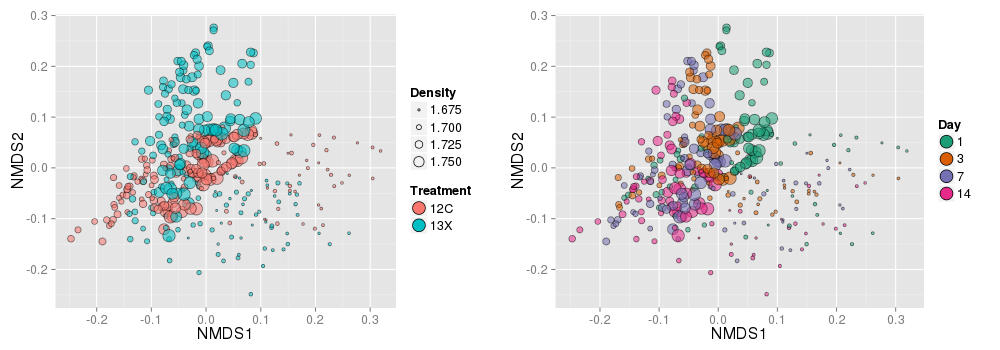

In [10]:
%%R -w 1000 -h 350
asNumeric = function(x) { as.numeric(as.character(x)) }

p1 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(fill = Treatment, size = asNumeric(BD), alpha = 0.85), pch=21) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) + labs(size = "Density") +
        theme(text = element_text(size=16)) 
      

p2 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(fill = factor(asNumeric(Day)), size = asNumeric(BD), alpha = 0.95), pch=21) +
        guides(alpha = FALSE, size = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        scale_fill_brewer("Day", palette = "Dark2") + theme(text = element_text(size=16)) 

p.combined = grid.arrange(p1, p2, ncol=2)
print(p.combined)

In [11]:
%%R -w 1000 -h 350
pdf("/home/chantal/Chazy/Chazy_SIP/data/figs/XylOrd_byDay.pdf", width = 12, height = 5)
grid.arrange(p1, p2, ncol=2)
dev.off()

png 
  2 


TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


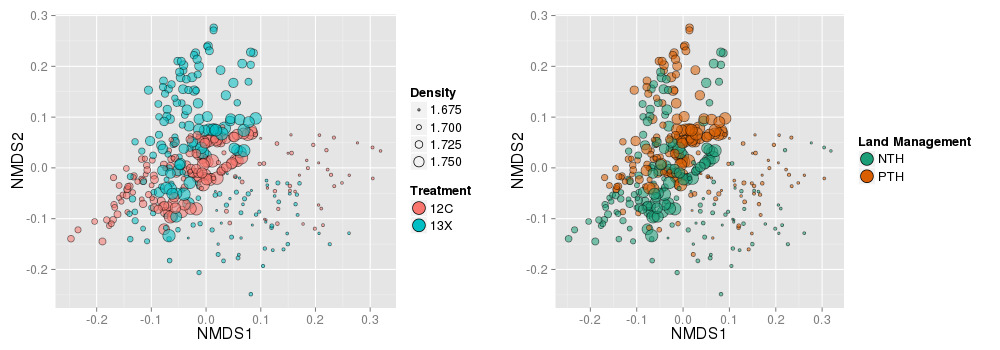

In [12]:
%%R -w 1000 -h 350
asNumeric = function(x) { as.numeric(as.character(x)) }

p1 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(fill = Treatment, size = asNumeric(BD), alpha = 0.85), pch=21) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) + labs(size = "Density") +
        theme(text = element_text(size=16)) 
      

p2 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(fill = factor(as.factor(Land_Management)), size = as.factor(BD), alpha = 0.95), pch=21) +
        guides(alpha = FALSE, size = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        scale_fill_brewer("Land Management", palette = "Dark2") + theme(text = element_text(size=16)) 

p.combined = grid.arrange(p1, p2, ncol=2)
print(p.combined)

In [13]:
%%R -w 1000 -h 350
pdf("/home/chantal/Chazy/Chazy_SIP/data/figs/XylOrd_byLM.pdf", width = 12, height = 5)
grid.arrange(p1, p2, ncol=2)
dev.off()

png 
  2 


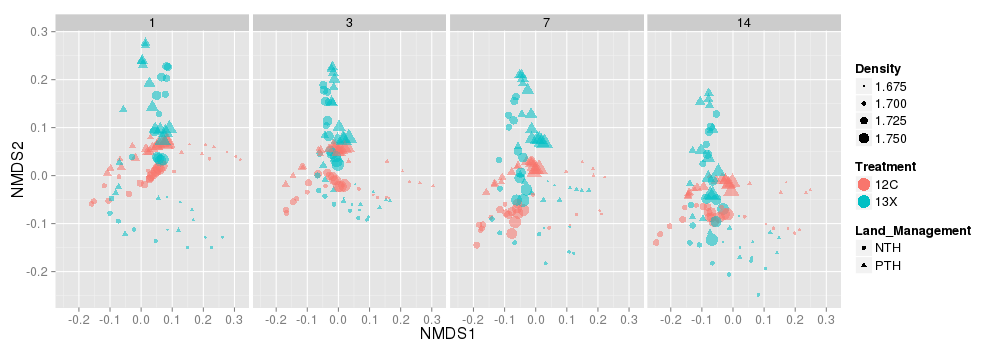

In [30]:
%%R -w 1000 -h 350
asNumeric = function(x) { as.numeric(as.character(x)) }


p1 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(shape = Land_Management, color = Treatment, fill = Treatment, size = asNumeric(BD), alpha = 0.85)) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) + labs(size = "Density") +
        theme(text = element_text(size=16)) 

p1 = p1 + facet_grid(~Day)

p1

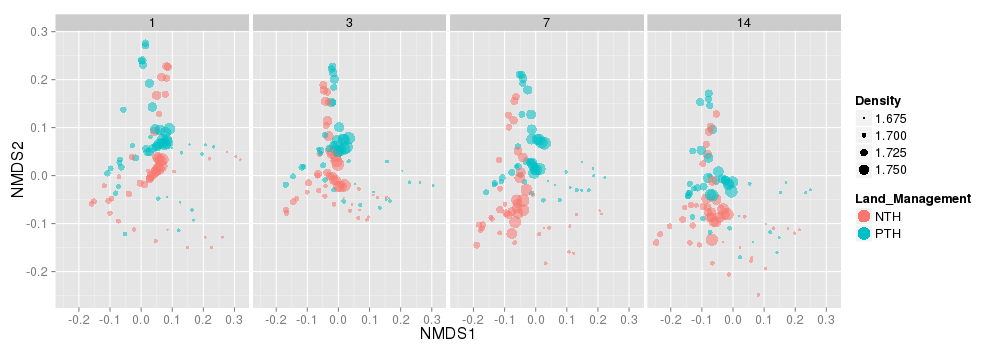

In [31]:
%%R -w 1000 -h 350
asNumeric = function(x) { as.numeric(as.character(x)) }


p1 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(color = Land_Management, fill = Land_Management, size = asNumeric(BD), alpha = 0.85)) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) + labs(size = "Density") +
        theme(text = element_text(size=16)) 

p1 = p1 + facet_grid(~Day)

p1

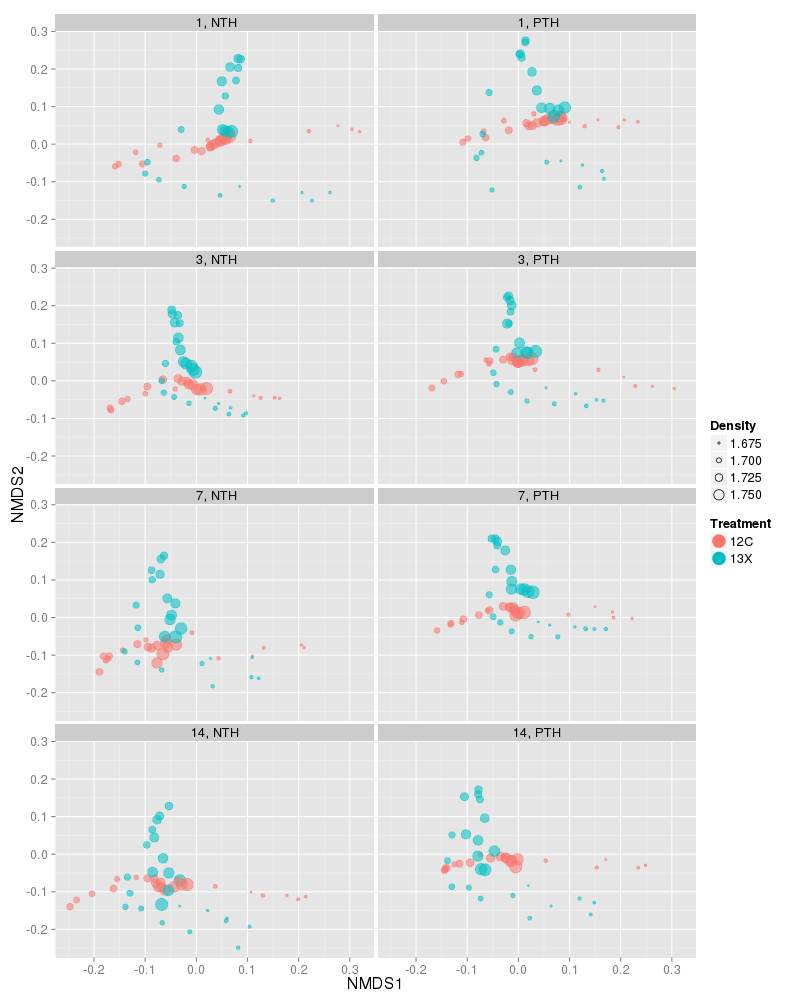

In [26]:
%%R -w 800 -h 1000
asNumeric = function(x) { as.numeric(as.character(x)) }


p1 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(color = Treatment, fill = Treatment, size = asNumeric(BD), alpha = 0.85), pch = 21) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) + labs(size = "Density") +
        theme(text = element_text(size=16)) 

p1 = p1 + facet_wrap(~Day + Land_Management, ncol = 2)

p1

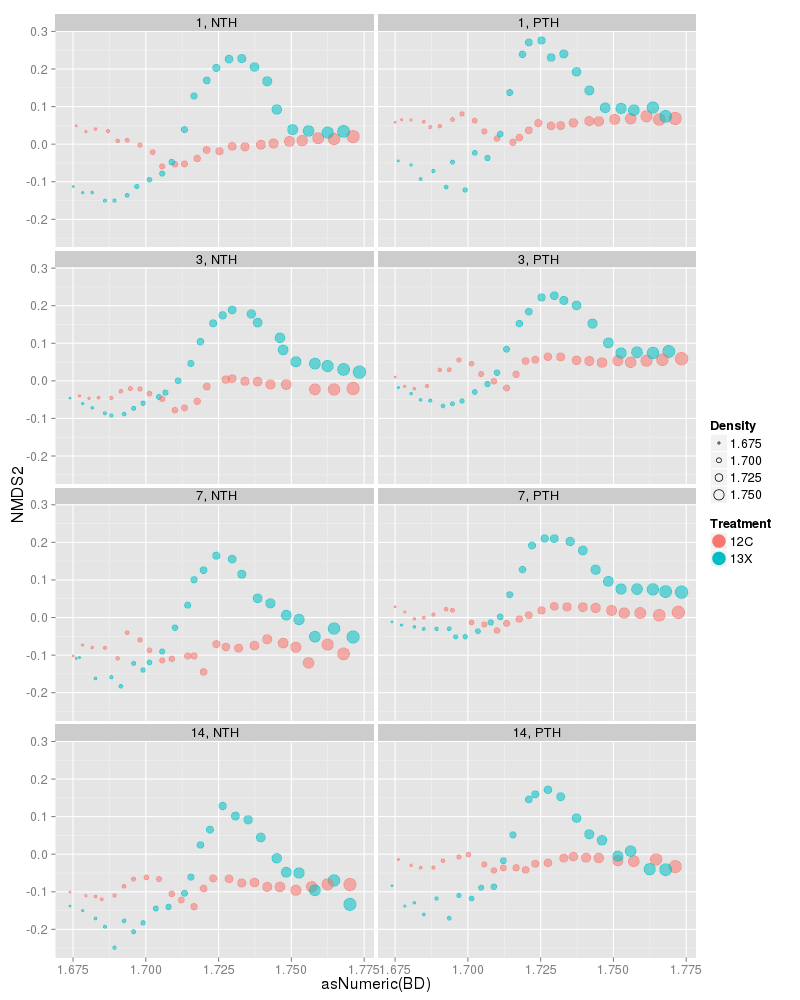

In [27]:
%%R -w 800 -h 1000
asNumeric = function(x) { as.numeric(as.character(x)) }


p1 = ggplot(p.nmds, aes(x = asNumeric(BD), y = NMDS2)) +  
        geom_point(aes(color = Treatment, fill = Treatment, size = asNumeric(BD), alpha = 0.85), pch = 21) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) + labs(size = "Density") +
        theme(text = element_text(size=16)) 

p1 = p1 + facet_wrap(~Day + Land_Management, ncol = 2)

p1

### Adonis Statistics ...NEED TO UPDATE

In [46]:
%%R 
physeq.data = as(sample_data(physeq.thresh_nopas), "data.frame")
adonis(wunif.dist.nopas ~ Treatment, physeq.data)



Error in sample_data(physeq.thresh_nopas) : 
  error in evaluating the argument 'object' in selecting a method for function 'sample_data': Error: object 'physeq.thresh_nopas' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in sample_data(physeq.thresh_nopas) : 
  error in evaluating the argument 'object' in selecting a method for function 'sample_data': Error: object 'physeq.thresh_nopas' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [25]:
%%R 
physeq.data = as(sample_data(physeq.thresh_nopas), "data.frame")
adonis(wunif.dist.nopas ~ OM, physeq.data)


Call:
adonis(formula = wunif.dist.nopas ~ OM, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)  
OM         1   0.02837 0.0283680  2.8865 0.04449  0.026 *
Residuals 62   0.60933 0.0098279         0.95551         
Total     63   0.63770                   1.00000         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [18]:
%%R 

physeq.data = as(sample_data(physeq.thresh_nopas), "data.frame")
adonis(wunif.dist.nopas ~ Till, physeq.data)


Call:
adonis(formula = wunif.dist.nopas ~ Till, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Till       1   0.07938 0.079380   8.815 0.12448  0.001 ***
Residuals 62   0.55832 0.009005         0.87552           
Total     63   0.63770                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [19]:
%%R 
physeq.data = as(sample_data(physeq.thresh_nopas), "data.frame")
adonis(wunif.dist.nopas ~ Month, physeq.data)


Call:
adonis(formula = wunif.dist.nopas ~ Month, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Month      3   0.12227 0.040758  4.7446 0.19174  0.001 ***
Residuals 60   0.51542 0.008590         0.80826           
Total     63   0.63770                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [21]:
%%R 
physeq.data = as(sample_data(physeq.thresh_nopas), "data.frame")
adonis(wunif.dist.nopas ~ Month*Treatment, physeq.data)

##R2 is similar between interaction and individual 
#Change in unit by month by treatment


Call:
adonis(formula = wunif.dist.nopas ~ Month * Treatment, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Month            3   0.12227 0.040758  6.2964 0.19174  0.001 ***
Treatment        3   0.12162 0.040539  6.2625 0.19071  0.001 ***
Month:Treatment  9   0.08309 0.009232  1.4262 0.13029  0.042 *  
Residuals       48   0.31072 0.006473         0.48725           
Total           63   0.63770                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
